<a href="https://colab.research.google.com/github/LeviCC8/SIBGRAPI-WIP-AEIMPS/blob/main/SIBGRAPI_WIP_AEIMPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
from google.colab import drive
import scipy.io

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.image import ssim

Dataset loading

In [ ]:
# load matfiles after mouting drive
drive.mount('gdrive')


mat_1 = scipy.io.loadmat('/content/gdrive/Shareddrives/IC/NRID/session_1_MOS_Value.mat')
mat_2 = scipy.io.loadmat('/content/gdrive/Shareddrives/IC/NRID/session_2_MOS_Value.mat')

mos = dict()

for variavel in mat_1['VQ_set_1']:
  mos[str(variavel[0][0])] = float(variavel[1])

for variavel in mat_2['VQ_set_2']:
  mos[str(variavel[0][0][0][0])] = float(variavel[1])

print('Loaded Mean Opinion Scores')

In [3]:
# creating TF dataset https://stackoverflow.com/questions/37340129/tensorflow-training-on-my-own-image

import tensorflow as tf
import os
from google.colab import drive

shape_image = (64, 64, 3)
# parse every image in the dataset using `map`
def _parse_function(filename):

    image_string = tf.io.read_file(filename)

    image_decoded = tf.image.decode_image(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32) / 255

    image = tf.image.resize_with_pad(
      image, shape_image[0], shape_image[1],
      method=tf.image.ResizeMethod.BILINEAR,
      antialias=False
    )
    #image = tf.image.rgb_to_grayscale(image)
    
    return image, image 

#### load-ish original images
_fname = lambda x : '/content/gdrive/Shareddrives/IC/NRID/original/{}'.format(x)

file_list = os.listdir('/content/gdrive/Shareddrives/IC/NRID/original')
file_list = [f for f in file_list if f.endswith('.png')]
filenames = tf.constant([ _fname(x) for x in file_list])

dataset = tf.data.Dataset.from_tensor_slices(filenames)
dataset = dataset.map(_parse_function)
dataset = dataset.batch(1)

NVAE loading

In [ ]:
!git clone https://github.com/NVlabs/NVAE.git

In [ ]:
!pip install onnx
!pip install tensorboardX

In [ ]:
%cd NVAE
from model import AutoEncoder
import torch
import utils
import torch.distributed as dist

os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '6020'
torch.cuda.set_device(0)
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=1)
path_model = '/content/gdrive/Shareddrives/IC/modelos/NVAE/celeba_64/checkpoint.pt'
checkpoint = torch.load(path_model, map_location='cpu')
args = checkpoint['args']
args.num_mixture_dec = 10

arch_instance = utils.get_arch_cells(args.arch_instance)
model = AutoEncoder(args, None, arch_instance)
model.load_state_dict(checkpoint['state_dict'], strict=False)
model = model.cuda()  

Plots of input images and their outputs by NVAE

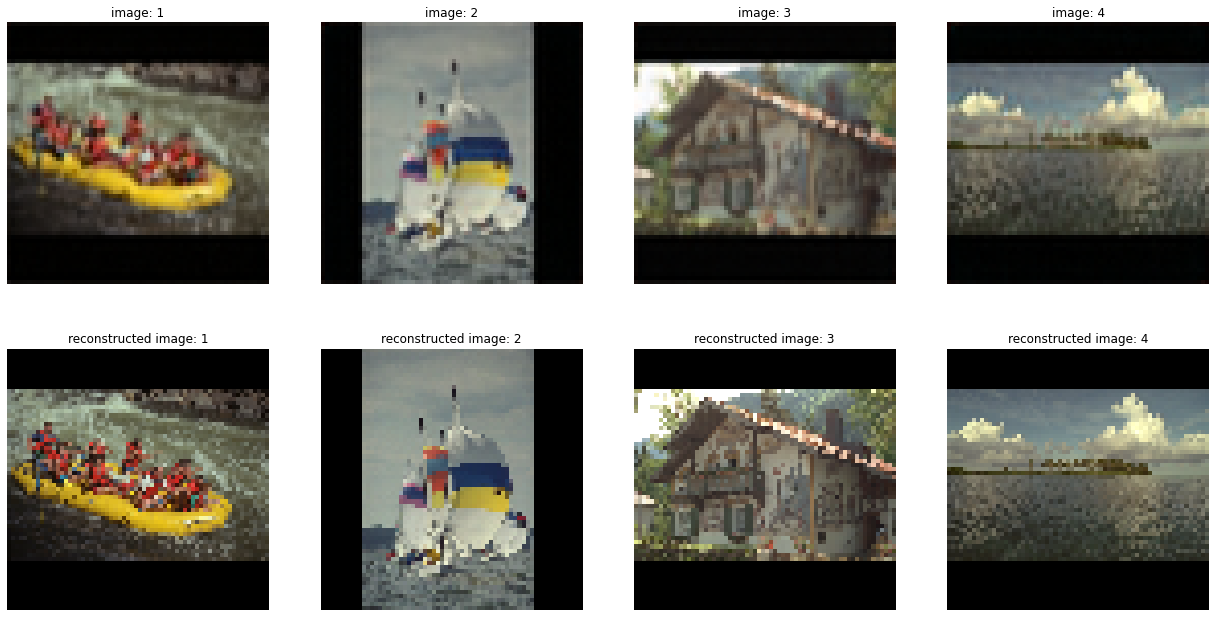

In [8]:
plt.figure(figsize=(44, 11))
count = 1


for image, _ in dataset.take(4):
  image_aux = tf.transpose(image, [0, 3, 1, 2])
  output = model(torch.Tensor(image_aux.numpy()).cuda())
  output = model.decoder_output(output[0])
  output = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
                      else output.sample()
  
  output = np.transpose(output.cpu().detach().numpy(), [0, 2, 3, 1])
  
  s = tf.reshape(output, tuple([1]) + shape_image)
  plt.subplot(2, 8, count)
  plt.title("image: " + str(count))
  plt.imshow(tf.reshape(s, shape_image), cmap='gray', vmin=0, vmax=1)
  plt.axis('off')


  plt.subplot(2, 8, (count + 8))
  plt.title("reconstructed image: " + str(count))
  plt.imshow(tf.reshape(image, shape_image), cmap='gray', vmin=0, vmax=1)
  plt.axis('off')
  count += 1
plt.show()

### MOS prediction

Computing fusion metrics

In [29]:
_fname = lambda x : '/content/gdrive/Shareddrives/IC/NRID/retargeted/{}'.format(x)
ret_list = list(mos.keys())
mos_list = []
fusion_metrics = {i+1: [] for i in range(13)}

for i, image in enumerate(dataset):
  image_name = file_list[i]
  image_name_in = image_name[:image_name.find('.')] + '_'
  #image = tf.expand_dims(image[0], 0)
  image_aux = tf.transpose(image[0], [0, 3, 1, 2])
  encoded_image = model(torch.Tensor(image_aux.numpy()).cuda())

  output = model.decoder_output(encoded_image[0])
  output_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
                        else output.sample()
  output_img = np.transpose(output_img.cpu().detach().numpy(), [0, 2, 3, 1])
  
  encoded_image = np.transpose(encoded_image[0].cpu().detach().numpy(), [0, 2, 3, 1])

  ret_image_names = [ret_image_name for ret_image_name in ret_list if image_name_in in ret_image_name]
  for ret_image_name in ret_image_names:
    
    ret_image, _ = _parse_function(_fname(ret_image_name))
    ret_image = tf.expand_dims(ret_image, 0)

    image_aux2 = tf.transpose(ret_image, [0, 3, 1, 2])
    encoded_ret_image = model(torch.Tensor(image_aux2.numpy()).cuda())
    
    output = model.decoder_output(encoded_ret_image[0])
    output_ret_img = output.mean if isinstance(output, torch.distributions.bernoulli.Bernoulli) \
                        else output.sample()
    output_ret_img = np.transpose(output_ret_img.cpu().detach().numpy(), [0, 2, 3, 1])
    
    encoded_ret_image = np.transpose(encoded_ret_image[0].cpu().detach().numpy(), [0, 2, 3, 1])
    

    cmae_I_deJ = float((1 - tf.reduce_mean(tf.abs(image[0] - output_ret_img))).numpy())
    cmae_J_deJ = float((1 - tf.reduce_mean(tf.abs(ret_image[0] - output_ret_img))).numpy())
    rho_factor = float(ret_image_name[ret_image_name.rfind('_')+1:ret_image_name.rfind('.')])
    avg_norm_channel = float(tf.reduce_mean(tf.norm(encoded_image - encoded_ret_image, axis=[1,2])).numpy())

    fusion_metrics[1].append(cmae_I_deJ)
    fusion_metrics[2].append(rho_factor*cmae_I_deJ)
    fusion_metrics[3].append(cmae_I_deJ/rho_factor)
    fusion_metrics[4].append(cmae_I_deJ**rho_factor)
    fusion_metrics[5].append(rho_factor**cmae_I_deJ)
    fusion_metrics[6].append(0.5*cmae_I_deJ + 0.5*rho_factor)
    fusion_metrics[7].append(0.8*cmae_I_deJ + 0.2*rho_factor)
    fusion_metrics[8].append(0.2*cmae_I_deJ + 0.8*rho_factor)
    fusion_metrics[9].append(0.1*cmae_I_deJ + 0.9*rho_factor)
    fusion_metrics[10].append(cmae_J_deJ)
    fusion_metrics[11].append(avg_norm_channel)
    fusion_metrics[12].append(rho_factor*avg_norm_channel)
    fusion_metrics[13].append(float(tf.norm(encoded_ret_image).numpy()))

    mos_list.append(mos[ret_image_name])

Defining the five-parameter logistic function estimator and the measurements

In [24]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

def cost(y_true, y_pred):
  return lambda betas: sum( (func(y_pred, *betas) - y_true) ** 2)

def func(x, b1, b2, b3, b4, b5):
  e = b2 * (x - b3)
  return 0.5 * b1 - b1 / (1 + np.exp(e)) + b4 * x + b5

def fit_poly5(y_true, y_pred, return_extras=False):
  res = minimize(cost(y_true, y_pred), x0=np.ones((1, 5)))
  # print(res.x) 

  return func(y_pred, *res.x), res

def rmse(y_true, y_pred):
  return mean_squared_error(y_true, y_pred) ** 0.5

def llc(y_true, y_pred):
  result, _ = pearsonr(y_true, y_pred)
  return result

def srcc(y_true, y_pred):
  result, _ = spearmanr(y_true, y_pred)
  return result

def outlier_ratio(y_true, y_pred):
  mos = np.mean(y_true)
  std = np.std(y_true)
  outliers = np.logical_or(y_pred < (mos - 2 * std), y_pred > (mos + 2 * std))
  return np.mean( outliers.astype(int) )

Computing the measurements for each fusion metric

In [ ]:
for i, values in fusion_metrics.items():
  objective_score, _ = fit_poly5(np.array(mos_list), np.array(values))
  results = [metric(mos_list, objective_score) for metric in (llc, srcc, rmse, outlier_ratio)]
  print(f'Fusion {i}:')
  print(f'LLC = {results[0]}\nSRCC = {results[1]}\nRMSE = {results[2]}\nOutlier ratio = {results[3]}')